In [5]:
#Author name: Satendra Yadav
#report and source code and outputs
# ques 4

## Importing Libraries

In [6]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.image as img
import os
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

## Loading images 

In [7]:
# Data input path:
BASE = 'Data/emotion_classification/'

In [8]:
filepaths_train = [] # Contains the absolute paths of all the image files
filepaths_test = []
for s_i in os.listdir(BASE+'train/'): # The folders containing the files are labelled as subject01.happy, subject02.happy, etc 
        filepaths_train.append(BASE+'train/' + s_i)
for s_i in os.listdir(BASE+'test/'): # The folders containing the files are labelled as as subject01.sad,etc 
        filepaths_test.append(BASE +'test/'+ s_i)

In [9]:
df1 = pd.DataFrame({'filepaths1':filepaths_train})  #dataframe to store filepaths of train images
df2 = pd.DataFrame({'filepaths2':filepaths_test})   #dataframe to store filepaths of test images

In [10]:
#storing train images in array named as x_train
images = []
for filepath in df1['filepaths1']:
    images.append(img.imread(filepath, 0).flatten())
x_train = np.array(images)


In [11]:
#storing test images in array named as x_test
images1 = []
for filepath in df2['filepaths2']:
    images1.append(img.imread(filepath, 0).flatten())
x_test = np.array(images1)


In [12]:
#storing train images labels in array named as train_y
label=[]
train_y=[]
for filepath in df1['filepaths1']:
    label.append(filepath[44:45])
for i in label:
    if i=='h':
        train_y.append(1)
    else:
        train_y.append(0)
y_train = np.array(train_y)   


In [13]:
#storing test images labels in array named as test_y
label=[]
test_y=[]
for filepath in df2['filepaths2']:
    label.append(filepath[43:44])
print(label)
for i in label:
    if i=='h':
        test_y.append(1)
    else:
        test_y.append(0)
y_test = np.array(test_y)   

['s', 'h', 'h', 's', 's', 'h', 'h', 'h', 'h', 's']


## Centering the data

In [14]:
data_mean = x_train.mean(axis=0)
x_train = x_train - data_mean
x_test = x_test - data_mean

In [15]:
# To extract the principal components using Singular value decomposition
# A_matrix = U_matrix S_matrix Vt_matrix
# columns of V_matrix are the eig vectors of the covariance matrix that are required to us.
# The eigen vectors are sorted according to the eigen values as required
U_matrix, S_matrix, Vt_matrix = np.linalg.svd(x_train, full_matrices=True)

# so the eigen values obtained are
S_matrix ** 2

array([8.13518673e+07, 3.93221461e+07, 3.24692516e+07, 1.93360217e+07,
       1.53448924e+07, 1.48530491e+07, 1.25407327e+07, 1.00795877e+07,
       7.86345772e+06, 7.54817924e+06, 6.45100542e+06, 6.26153115e+06,
       4.74969176e+06, 4.23894861e+06, 3.60987178e+06, 3.39283628e+06,
       2.89195650e+06, 2.46185219e+06, 1.73952015e+06, 5.63576924e-24])

In [16]:
# principal components
components = Vt_matrix.T

In [17]:
# After performing for different values 
#we will perform this for only a single value of K
#by running different k we observed k= 18 gives optimal result as accuracy of 90%
K = 18

In [18]:
pca_k_train_x = np.matmul(x_train, components[: , :K])
pca_k_test_x = np.matmul(x_test, components[: , :K])

In [19]:
pca_k_train_x.shape, pca_k_test_x.shape

((20, 18), (10, 18))

In [20]:
# class means
M0 = pca_k_train_x[y_train == 0].mean(axis=0)
M1 = pca_k_train_x[y_train == 1].mean(axis=0)

In [21]:
pca_k_train_x.shape, pca_k_test_x.shape

((20, 18), (10, 18))

In [22]:
# between class scatter matrix
S_b = np.outer((M1 - M0), (M1 - M0).T)

In [23]:
# within class scatter matrix
S_w = np.zeros_like(S_b)
for i, sample in enumerate(pca_k_train_x):
    if train_y[i] == 0:
        S_w = S_w + np.outer((sample - M0), (sample - M0).T)
    else:
        S_w = S_w + np.outer((sample - M1), (sample - M1).T)

In [24]:
'''The following is a slightly different approach for finding the projection vector'''
# for linear projection constants don't make a difference, so
# W = lambda (inv(S_w) @ S_b @ W)
# S_b @ W = (M1 - M0) @ (M1 - M0).T @ W = k (M1 - M0), where k = (m1 - m0)
# Thus, W = inv(S_w) @ (M1 - M0)
W = np.matmul(np.linalg.inv(S_w), (M1 - M0).reshape(-1, 1))

In [25]:
x_lda_train = np.matmul(pca_k_train_x, W).reshape(-1)
x_lda_test = np.matmul(pca_k_test_x, W).reshape(-1)

In [26]:
# find max and min value for the projected value of each class
max_0, min_0 = np.max(x_lda_train[y_train == 0]), np.min(x_lda_train[y_train == 0])
max_1, min_1 = np.max(x_lda_train[y_train == 1]), np.min(x_lda_train[y_train == 1])

In [27]:
# maximum separability threshold - heuristic
threshold_start, threshold_end = min(max_0, max_1), max(min_0, min_1)
optimal_threshold = (threshold_start + threshold_end) / 2
# threshold value after multiple runs with different values of K
# can be seen to be closer to 0. 
# Using optimal_threshold = 0 is thus a better choice than using the
# above heuristic

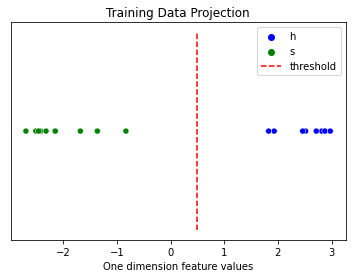

In [28]:
sns.scatterplot(x=x_lda_train, y=[0]*len(y_train), hue=['h' if s_class == 1 else 's' for s_class in y_train], palette=['blue', 'green'])
plt.vlines(optimal_threshold, -1, 1, colors='r', linestyles='--', label='threshold')
plt.xlabel('One dimension feature values')
plt.yticks([])
plt.title('Training Data Projection')
plt.legend()
plt.show()

In [29]:
class_1_majority

NameError: name 'class_1_majority' is not defined

In [ ]:
classification_test_labels = [1 if class_1_majority * sample_class >= class_1_majority * optimal_threshold else 0 
                                  for sample_class in lda_test_x]
accuracy = sum([yhat == y for yhat, y in zip(classification_test_labels, test_y)]) / len(test_y) * 100
accuracy

In [ ]:
#Fisher ratio calculation 
J = (np.matmul(np.matmul(W.T, S_b) , W) / np.matmul(W.T, np.matmul(S_w, W)))[0, 0]
print(J)